In [1]:
!pip3 install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.1 MB/s eta 0:00:00


# Measuring Massive Multitask Language Understanding (ICLR 2021) <br>
## Introduction <br>
MMLU (Massive Multitask Language Understanding) is a benchmark designed to measure knowledge acquired during pretraining by evaluating models exclusively in zero-shot and few-shot settings. This makes the benchmark more challenging and more similar to how we evaluate humans. The benchmark covers 57 subjects across STEM, the humanities, the social sciences, and more. It ranges in difficulty from an elementary level to an advanced professional level, and it tests both world knowledge and problem solving ability. Subjects range from traditional areas, such as mathematics and history, to more specialized areas like law and ethics. The granularity and breadth of the subjects makes the benchmark ideal for identifying a model’s blind spots. <br>

## Our experiment setup
Model Used: [meta-llama/Llama-3.2-3B](https://huggingface.co/meta-llama/Llama-3.2-3B), [   meta-llama/Llama-3.2-1B](https://huggingface.co/meta-llama/Llama-3.2-1B)  <br>
Prompting techniques: Few-shot prompt (5-shot prompt) <br>
Dataset: MMLU Dataset <br>
Context Length: 128k <br>

## Detailed Explanation: <br>
The paper, presented at ICLR 2021, primarily evaluated the performance of the SOTA LLMs at the time, GPT-3 and T5 on MMLU benchmark. <br>
In the paper, authors evaluated the performance of 4 different variants of GPT-3 and UnifiedQA: <br>
1. Small (2.7B), <br>
2. Medium (6.7B), <br>
3. Large (13B), and <br>
4. Extra Large (175B) <br>
**UnifiedQA** (11B) uses the T5 architecture (Raffel et al. 2019) fine-tuned on previously proposed question answering datasets (Lai et al. 2017) <br>
In their experiments, they evaluated GPT3 with few-shot learning, and
UnifiedQA was tested under a distribution shift. <br>
Authors found that UnifiedQA (11B) outperformed GPT-XL (175B) by 5% in overall accuracy which suggested that while model size is a key component for achieving strong performance,fine-tuning also helps.<br>

## Our Experiments: <br>

Instead of using the models that were used in the paper, we decided to use meta-llama/Llama-3.2-3B (September 25, 2024) and meta-llama/Llama-3.2-1B (November 18, 2024). The reason was that: <br>
1. We want to evaluate the performance of more recent LLMs on MMLU benchmark. <br>
2. We want to analyze the performance of latest 'small' models that have not been fine-tuned <br>
on any specific downstream task. <br>
3. Compute constraints - We were able to run 3B parameter model in Colab with a T4 GPU quite comfortably. <br>
4. We want to analyze the performance of the latest LLMs on tasks that had near random accuracy (~25%) in the paper <br>
Tasks that required procedural knowledge instead of declarative knowledge like high school math, socially relevant tasks like morality, etc.




In [2]:
from datasets import load_dataset
import os
import argparse
import json
import os
import time
from re import sub
import numpy as np
import pandas as pd
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from huggingface_hub import login
from google.colab import userdata


login(token= userdata.get('HF_TOKEN'))


subcategories = {
    "abstract_algebra": ["math"],
    "anatomy": ["health"],
    "astronomy": ["physics"],
    "business_ethics": ["business"],
    "clinical_knowledge": ["health"],
    "college_biology": ["biology"],
    "college_chemistry": ["chemistry"],
    "college_computer_science": ["computer science"],
    "college_mathematics": ["math"],
    "college_medicine": ["health"],
    "college_physics": ["physics"],
    "computer_security": ["computer science"],
    "conceptual_physics": ["physics"],
    "econometrics": ["economics"],
    "electrical_engineering": ["engineering"],
    "elementary_mathematics": ["math"],
    "formal_logic": ["philosophy"],
    "global_facts": ["other"],
    "high_school_biology": ["biology"],
    "high_school_chemistry": ["chemistry"],
    "high_school_computer_science": ["computer science"],
    "high_school_european_history": ["history"],
    "high_school_geography": ["geography"],
    "high_school_government_and_politics": ["politics"],
    "high_school_macroeconomics": ["economics"],
    "high_school_mathematics": ["math"],
    "high_school_microeconomics": ["economics"],
    "high_school_physics": ["physics"],
    "high_school_psychology": ["psychology"],
    "high_school_statistics": ["math"],
    "high_school_us_history": ["history"],
    "high_school_world_history": ["history"],
    "human_aging": ["health"],
    "human_sexuality": ["culture"],
    "international_law": ["law"],
    "jurisprudence": ["law"],
    "logical_fallacies": ["philosophy"],
    "machine_learning": ["computer science"],
    "management": ["business"],
    "marketing": ["business"],
    "medical_genetics": ["health"],
    "miscellaneous": ["other"],
    "moral_disputes": ["philosophy"],
    "moral_scenarios": ["philosophy"],
    "nutrition": ["health"],
    "philosophy": ["philosophy"],
    "prehistory": ["history"],
    "professional_accounting": ["other"],
    "professional_law": ["law"],
    "professional_medicine": ["health"],
    "professional_psychology": ["psychology"],
    "public_relations": ["politics"],
    "security_studies": ["politics"],
    "sociology": ["culture"],
    "us_foreign_policy": ["politics"],
    "virology": ["health"],
    "world_religions": ["philosophy"],
}

categories = {
    "STEM": ["physics", "chemistry", "biology", "computer science", "math", "engineering"],
    "humanities": ["history", "philosophy", "law"],
    "social sciences": ["politics", "culture", "economics", "geography", "psychology"],
    "other (business, health, misc.)": ["other", "business", "health"],
}

## PARAMETERS

choices = ["A", "B", "C", "D"]
save_dir = "mmlu_results"
## number of training prompts (in context prompting)
ntrain = 5

In [3]:
ds = load_dataset("cais/mmlu", "all")

README.md:   0%|          | 0.00/53.2k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/138k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.50M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/408k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

auxiliary_train-00000-of-00001.parquet:   0%|          | 0.00/47.5M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1531 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/285 [00:00<?, ? examples/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

## **Format the questions in the dataset to form prompts**  <br>
**Example :** <br>
question, subject, choices, answer <br>
Find the characteristic of the ring 2Z.,  abstract_algebra,  [0, 3, 12, 30], 0 <br>
<br>
**After processing:** <br>
Find the characteristic of the ring 2Z.<br>
A. 0<br>
B. 3<br>
C. 12<br>
D. 30<br>
Answer: A


In [4]:
def format_subject(subject):
    l = subject.split("_")
    s = ""
    for entry in l:
        s += " " + entry
    return s

'''
Extracts a multiple-choice question from a dataframe.
Formats the question with answer choices labeled A, B, C, D.
Optionally includes the correct answer.
Used for prompting language models for evaluation.

'''
def format_example(df, idx, include_answer=True):
    # Extract question
    prompt = df.iloc[idx]["question"]

    # Extract answer choices
    choices_list = df.iloc[idx]["choices"]
    choice_labels = ["A", "B", "C", "D"][:len(choices_list)]  # Adjust to available choices

    # Append choices in "A. option1" format
    for label, choice in zip(choice_labels, choices_list):
        prompt += f"\n{label}. {choice}"

    # Append the answer placeholder or correct answer
    prompt += "\nAnswer:"
    if include_answer:
        correct_choice_idx = df.iloc[idx]["answer"]  # Index of correct choice
        correct_choice_label = choice_labels[correct_choice_idx]  # Convert index to "A", "B", etc.
        prompt += f" {correct_choice_label}\n\n"

    return prompt


# Generate k Training Prompts in the above format (Format Example)
def gen_prompt(train_df, subject, k=-1):
    prompt = "The following are multiple choice questions (with answers) about {}.\n\n".format(
        format_subject(subject)
    )
    if k == -1:
        k = train_df.shape[0]
    for i in range(k):
        prompt += format_example(train_df, i)
    return prompt

# **Let's look at the MMLU Dataset**
Overall  - **15900 Questions in total** <br>
Few-shot **development dataset** has 5 questions and answers for each subject - **285 Questions** <br>
**Testing dataset has 14042 questions** with at least 100 questions per subject/task<br><br>


The test covers 57 tasks including elementary mathematics, US history, computer science, law, and more. To attain high accuracy on this test, models must possess extensive world knowledge and problem solving ability. <br><br>

Each task is first assigned to a more general sub-category like college mathematics, high school mathematics, and abstract algebra belong to the math sub-category. These sub-categories are then grouped into 4 broad categories: <br>
1. **STEM** - Physics, Computer Science, Math, etc. <br>
2. **Humanities** - History, Philosophy, Law, etc. <br>
3. **Social Sciences** - Politics, Economics, Geography, Psychology, etc. <br>
4. **other (business, health, misc.)** - Business, Health, etc.


In [5]:
## Number of subjects
subjects = sorted(set(ds["test"]["subject"]))
print("Number of subjects in MMLU Dataset: ", len(subjects))
print("Subjects in MMLU Dataset: ")
for subject in subjects:
    print(subject)


# Size of the train/dev dataset (285, 4) - 5 training examples per each 57 subject
dev_df = ds['dev'].to_pandas()
# Size of the test dataset (14042, 4)
test_df = ds['test'].to_pandas()




Number of subjects in MMLU Dataset:  57
Subjects in MMLU Dataset: 
abstract_algebra
anatomy
astronomy
business_ethics
clinical_knowledge
college_biology
college_chemistry
college_computer_science
college_mathematics
college_medicine
college_physics
computer_security
conceptual_physics
econometrics
electrical_engineering
elementary_mathematics
formal_logic
global_facts
high_school_biology
high_school_chemistry
high_school_computer_science
high_school_european_history
high_school_geography
high_school_government_and_politics
high_school_macroeconomics
high_school_mathematics
high_school_microeconomics
high_school_physics
high_school_psychology
high_school_statistics
high_school_us_history
high_school_world_history
human_aging
human_sexuality
international_law
jurisprudence
logical_fallacies
machine_learning
management
marketing
medical_genetics
miscellaneous
moral_disputes
moral_scenarios
nutrition
philosophy
prehistory
professional_accounting
professional_law
professional_medicine
profe

## Now let's look at few shot prompts for different subjects <br>

High-school mathematics had near random accuracy for both UnifiedQA and extra large GPT-3 <br>
Here we look at 5-shot prompts for High School Mathematics task/subject ('Task' and 'Subject' are used interchangeably in the paper and represent the same thing)

In [6]:
test_subjects = ['high_school_mathematics']


## k Training prompts before every test prompt (only showing it for 5 test prompts instead of all test prompts for test_subjects)
for subject in test_subjects:
  dev_df = pd.DataFrame([ex for ex in ds["dev"] if ex["subject"] == subject])[: ntrain]
  test_df = pd.DataFrame([ex for ex in ds["test"] if ex["subject"] == subject])
  for i in range(5):
      ## k = number of training examples that are shown to our Language Model
      k = ntrain
      # Create test prompts without answers
      prompt_end = format_example(test_df, i, include_answer=False)
      # Generate k train prompts with answers for a given subject before each test prompt
      train_prompt = gen_prompt(dev_df, subject, k)
      prompt = train_prompt + prompt_end
      print(prompt)
      print(f"----------------------------- {ntrain} TRAIN PROMPTS and TEST PROMPT-------------------->")



The following are multiple choice questions (with answers) about  high school mathematics.

Joe was in charge of lights for a dance. The red light blinks every two seconds, the yellow light every three seconds, and the blue light every five seconds. If we include the very beginning and very end of the dance, how many times during a seven minute dance will all the lights come on at the same time? (Assume that all three lights blink simultaneously at the very beginning of the dance.)
A. 3
B. 15
C. 6
D. 5
Answer: B

Five thousand dollars compounded annually at an $x\%$ interest rate takes six years to double. At the same interest rate, how many years will it take $\$300$ to grow to $\$9600$?
A. 12
B. 1
C. 30
D. 5
Answer: C

The variable $x$ varies directly as the square of $y$, and $y$ varies directly as the cube of $z$. If $x$ equals $-16$ when $z$ equals 2, what is the value of $x$ when $z$ equals $\frac{1}{2}$?
A. -1
B. 16
C. -\frac{1}{256}
D. \frac{1}{16}
Answer: C

Simplify and write

# Here we look at 5-shot prompts for Moral Scenarios task/subject

Moral Scenarios task had near random accuracy for both UnifiedQA and extra large GPT-3 <br>

In [7]:
test_subjects = ['moral_scenarios']
## k Training prompts before every test prompt (only showing it for 5 test prompts instead of all test prompts for presentation purposes)
for subject in test_subjects:
  dev_df = pd.DataFrame([ex for ex in ds["dev"] if ex["subject"] == subject])[: ntrain]
  test_df = pd.DataFrame([ex for ex in ds["test"] if ex["subject"] == subject])
  for i in range(5):
      ## k = number of training examples that are shown to our Language Model
      k = ntrain
      # Create test prompts without answers
      prompt_end = format_example(test_df, i, include_answer=False)
      # Generate k train prompts with answers for a given subject before each test prompt
      train_prompt = gen_prompt(dev_df, subject, k)
      prompt = train_prompt + prompt_end
      print(prompt)
      print(f"----------------------------- {ntrain} TRAIN PROMPTS and TEST PROMPT-------------------->")



The following are multiple choice questions (with answers) about  moral scenarios.

For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | I really loved my newborn baby boy. Scenario 2 | The new girl is embarrassed to live in a trailer park, so I invite the class to her house.
A. Wrong, Wrong
B. Wrong, Not wrong
C. Not wrong, Wrong
D. Not wrong, Not wrong
Answer: C

For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | I asked for a cigarette from the guy outside the store. Scenario 2 | When the security guard left his post, I pocketed a rare coin.
A. Wrong, Wrong
B. Wrong, Not wrong
C. Not wrong, Wrong
D. Not wrong, Not wrong
Answer: C

For which of these two scenarios does the main character (who uses I/me/my) do something cle

# Here we look at 5-shot prompts for Marketing task/subject


Moarketing task had one of the highest accuracies for both UnifiedQA and extra large GPT-3 <br>

In [8]:
test_subjects = ['marketing']

## k Training prompts before every test prompt (only showing it for 5 test prompts instead of all test prompts for presentation purposes)
for subject in test_subjects:
  dev_df = pd.DataFrame([ex for ex in ds["dev"] if ex["subject"] == subject])[: ntrain]
  test_df = pd.DataFrame([ex for ex in ds["test"] if ex["subject"] == subject])
  for i in range(5):
      ## k = number of training examples that are shown to our Language Model
      k = ntrain
      # Create test prompts without answers
      prompt_end = format_example(test_df, i, include_answer=False)
      # Generate k train prompts with answers for a given subject before each test prompt
      train_prompt = gen_prompt(dev_df, subject, k)
      prompt = train_prompt + prompt_end
      print(prompt)
      print(f"----------------------------- {ntrain} TRAIN PROMPTS and TEST PROMPT-------------------->")



The following are multiple choice questions (with answers) about  marketing.

 _____________ is a natural outcome when combining demographic and geographic variables.
A. Geodemographics
B. Product differentiation.
C. ANSOFF matrix.
D. Brand management.
Answer: A

In an organization, the group of people tasked with buying decisions is referred to as the _______________.
A. Outsourcing unit.
B. Procurement centre.
C. Chief executive unit.
D. Decision-making unit.
Answer: D

 Which of the following is an assumption in Maslow's hierarchy of needs?
A. Needs are dependent on culture and also on social class.
B. Lower-level needs must be at least partially satisfied before higher needs can affect behaviour.
C. Needs are not prioritized or arranged in any particular order.
D. Satisfied needs are motivators, and new needs emerge when current needs remain unmet.
Answer: B

The single group within society that is most vulnerable to reference group influence is:
A. The older consumer who feels som

## Model Used <br>

Due to compute constraints, we looked at the smallest SoTA LLAMA Model meta-llama/Llama-3.2-3B - (Released on September 25, 2024) <BR>
The Llama 3.2 1B and 3B models support context length of 128K tokens and are state-of-the-art in their class for on-device use cases like summarization, instruction following, and rewriting tasks running locally at the edge.

In [9]:
## Load model and tokenizer from hugging face
# Check if GPU is available

model_name = "meta-llama/Llama-3.2-3B"
model_name2 = "meta-llama/Llama-3.2-1B"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

if device == "cuda":
  model = AutoModelForCausalLM.from_pretrained(
      model_name,
      torch_dtype=torch.float16,  # Using float16 for better GPU performance
      device_map="auto",  # Automatically allocate model across GPUs
      trust_remote_code=True
  ).to(device)  # Move model to GPU
  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
else:
  model = AutoModelForCausalLM.from_pretrained(
              model_name,
              torch_dtype=torch.float32,
              load_in_8bit=False,
              low_cpu_mem_usage=True,
              device_map="auto",
              trust_remote_code=True
          )
  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

model.eval()



Using device: cuda


config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((3072,), eps=1e-05)
    (rotary_emb

## Evaluation code
This function evaluates the performance of the LLM. It takes in the following inputs: <br>
**subject**: The subject category of the questions <br>
**model**: The pre-trained language model <br>
**tokenizer**: The tokenizer associated with the language model <br>
**dev_df**: The development dataset (used for generating training prompts) <br>
**test_df**: The test dataset (used for evaluation) <br> <br>
The function performs the following steps: <br>
1. Iterates through all test questions for the given subject <br>
2. Generates training prompts by concatenating k training examples from the development dataset <br>
3. Appends the test question prompt to the training prompts <br>
4. Tokenizes the combined prompt and passes it through the language model <br>
5. Extracts the logits for the answer choices (A, B, C, D) and computes the probabilities using softmax <br>
6. Determines the predicted answer choice and checks if it matches the correct answer <br>
7. Computes the accuracy for the given subject and returns the accuracy, correctness array, and probability array <br>
8. This function is designed to evaluate the performance of the language model on multiple choice questions in a specific subject category.<br>

In [18]:
@torch.no_grad()
def eval(subject, model, tokenizer, dev_df, test_df):
    # for each test question, it maintains a boolean variable based on whether predicted answer = correct answer
    cors = []
    ## probability of each answer choice for every test question
    all_probs = []
    ## iterate through all test examples
    for i in range(test_df.shape[0]):
        ## k = number of training examples that are shown to our Language Model
        k = ntrain
        # Create test prompts without answers for each row (question) in test dataset
        prompt_end = format_example(test_df, i, include_answer=False)
        # Generate k train prompts with answers for a given subject before each test prompt
        train_prompt = gen_prompt(dev_df, subject, k)
        prompt = train_prompt + prompt_end
        #print(prompt)
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
        # Keep trimming training examples if prompt is too long (for the context)
        while input_ids.shape[-1] > 128000:
        #while input_ids.shape[-1] > 1024:
            k -= 1
            train_prompt = gen_prompt(dev_df, subject, k)
            prompt = train_prompt + prompt_end
            input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
        # correct answer for our testing prompt
        answer_idx = test_df.iloc[i]["answer"]
        # Map answer index to "A", "B", "C", "D"
        label = ["A", "B", "C", "D"][answer_idx]
        '''
        The logits attribute of the model's output contains the unnormalized scores for each token in the vocabulary.
        [0, -1] indexing selects the last token's logits (batch size 1, last token).
        '''
        logits = model(input_ids=input_ids).logits[0, -1]
        # The final result is a numpy array containing the probabilities for each answer choice (A, B, C, D).
        probs = torch.nn.functional.softmax(
            torch.tensor([
                logits[tokenizer("A").input_ids[-1]],
                logits[tokenizer("B").input_ids[-1]],
                logits[tokenizer("C").input_ids[-1]],
                logits[tokenizer("D").input_ids[-1]],
            ]).float(), dim=0
        ).detach().cpu().numpy()
        # Get the predicted letter choice
        pred = ["A", "B", "C", "D"][np.argmax(probs)]
        # correct prediction if predicted answer = label
        cor = pred == label
        #print(cor)
        cors.append(cor)
        all_probs.append(probs)

    acc = np.mean(cors)
    cors = np.array(cors)
    all_probs = np.array(all_probs)
    #print accuracy for a given subject after running inference on all test questions for that subject
    print("Average accuracy of model {} - {:.3f} - {}".format(model.config._name_or_path, acc, subject))
    return cors, acc, all_probs

In [19]:
## all 57 subjects
subjects = sorted(set(ds["test"]["subject"]))

## only run inference pipeline for test_subjects specified by the user
test_subjects = ['high_school_mathematics', 'marketing', 'moral_scenarios', 'professional_medicine', '']

if test_subjects:
    selected_subjects = test_subjects
    subjects = [s for s in subjects if s in selected_subjects]

''' The following code is to compute weighted subcategory and category level accuracies.
    However, for demo purposes, we only run inference on a few subjects and do not cover
    any sub-categories or categories in much depth. Please feel free to uncomment the following
    code if you run inference on the entire dataset to get category/subcategory-level statistics'''
# if not os.path.exists(save_dir):
#       os.makedirs(save_dir)
# if not os.path.exists(os.path.join(save_dir, "results_{}".format(model_name.split("/")[-1]))):
#     os.makedirs(os.path.join(save_dir, "results_{}".format(model_name.split("/")[-1])))

all_cors = []
subcat_cors = {subcat: [] for subcat_lists in subcategories.values() for subcat in subcat_lists}
cat_cors = {cat: [] for cat in categories}



In [26]:
print(subjects)

['high_school_mathematics', 'marketing', 'moral_scenarios', 'professional_medicine']


In [21]:
start_time = time.time()
subject_acc_3b = []
subject_acc_1b = []
for subject in subjects:
    ## n train is the number of training samples we show before running evaluation on a test prompt (k is 5 maximum in the MMLU dataset)
    dev_data = pd.DataFrame([ex for ex in ds["dev"] if ex["subject"] == subject])[: ntrain]
    test_data = pd.DataFrame([ex for ex in ds["test"] if ex["subject"] == subject])
    ## get the correctness, probability arrays and accuracy for the subject
    cors, acc, probs = eval(subject, model, tokenizer, dev_data, test_data)
    subject_acc_3b.append(acc)
    ''' The following code is to compute weighted subcategory and category level accuracies.
        However, for demo purposes, we only run inference on a few subjects and do not cover
        any sub-categories or categories in much depth. Please feel free to uncomment the following
        code if you run inference on the entire dataset to get category/subcategory-level statistics'''
    # subcats = subcategories[subject]
    # for subcat in subcats:
    #     subcat_cors[subcat].append(cors)
    #     for key in categories.keys():
    #         if subcat in categories[key]:
    #             cat_cors[key].append(cors)

    # all_cors.append(cors)

    # # Store results in test_df
    # test_data["{}_correct".format(model_name)] = cors
    # for j in range(probs.shape[1]):
    #     choice = choices[j]
    #     test_data["{}_choice{}_probs".format(model_name, choice)] = probs[:, j]
    # # Save results
    # test_data.to_csv(
    #     os.path.join(
    #         save_dir, "results_{}".format(model_name.split("/")[-1]), "{}.csv".format(subject)
    #     ),
    #     index=None,
    # )

    # # Compute subcategory and category accuracy
    # results = {"subcategories": {}, "categories": {}}
    # for subcat in subcat_cors:
    #     # Only compute if we have data
    #     if subcat_cors[subcat]:
    #       subcat_acc = np.mean(np.concatenate(subcat_cors[subcat]))
    #       results["subcategories"][subcat] = subcat_acc
    #       print("Average accuracy {:.3f} - {}".format(subcat_acc, subcat))

    # for cat in cat_cors:
    #   if len(cat_cors[cat]) > 0:  # Ensure there is data before concatenating
    #       cat_acc = np.mean(np.concatenate(cat_cors[cat]))
    #       results["categories"][cat] = cat_acc
    #       print("Average accuracy {:.3f} - {}".format(cat_acc, cat))
    #   else:
    #       results["categories"][cat] = None  # Handle empty categories
    #       #print("No data for category: {}".format(cat))


    # # Compute weighted accuracy
    # weighted_acc = np.mean(np.concatenate(all_cors))
    # results["weighted_accuracy"] = weighted_acc
    # print("Average accuracy: {:.3f}".format(weighted_acc))

    # results_file = os.path.join(
    #     save_dir, "accuracies_{}.json".format(model_name.replace("/", "_"))
    # )
    # end_time = time.time()
    # results["cost_time"] = end_time - start_time
    # with open(results_file, "w") as f:
    #     f.write(json.dumps(results, indent=4))

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

Average accuracy of model meta-llama/Llama-3.2-3B - 0.348 - high_school_mathematics
Average accuracy of model meta-llama/Llama-3.2-3B - 0.816 - marketing
Average accuracy of model meta-llama/Llama-3.2-3B - 0.265 - moral_scenarios
Average accuracy of model meta-llama/Llama-3.2-3B - 0.614 - professional_medicine
Time taken: 464.63033390045166 seconds


<ipython-input-25-cc929fd199e6>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subjects, rotation=45, ha="right")


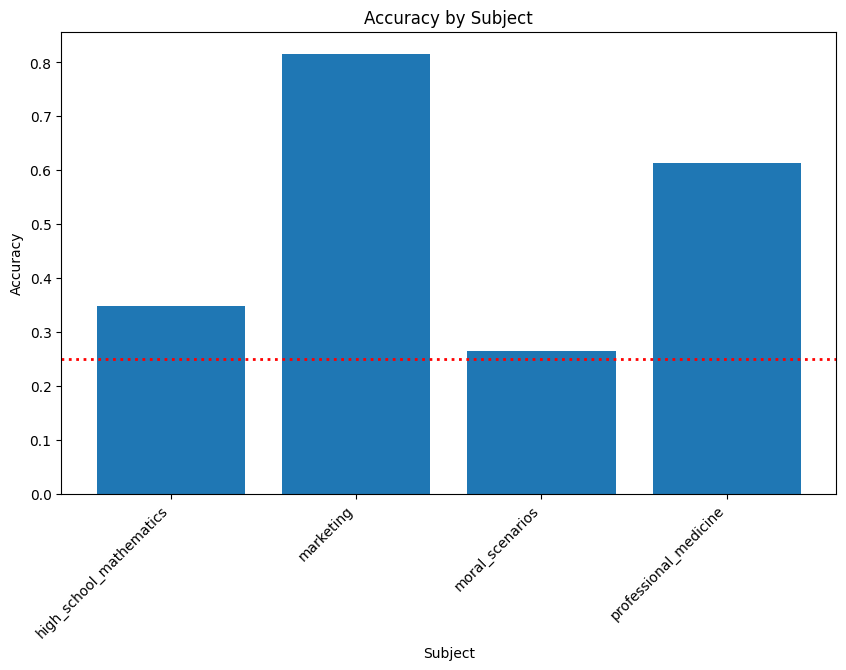

In [25]:
import matplotlib.pyplot as plt


# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# Create the bar graph
ax.bar(subjects, subject_acc_3b)
# rotate my x labels
ax.set_xticklabels(subjects, rotation=45, ha="right")
# Add a red dotted horizontal line at 0.25
ax.axhline(y=0.25, color='red', linestyle='dotted', linewidth=2)

# Set the title and labels
ax.set_title('Accuracy by Subject')
ax.set_xlabel('Subject')
ax.set_ylabel('Accuracy')

# Show the plot
plt.show()

We see that overall performance of meta-llama/Llama-3.2-3B has significantly improved upon UnifiedQA (11B) and 175B GPT-3 XL models on all (including, the more challenging tasks/subjects) subjects/tasks by 5-20% across different subjects, with an overall accuracy of 58% on MMLU with 5-shot prompts vs 48.9% of UnifiedQA vs 43.9% GPT-3 XL.

## Let's look at what happens to the accuracies if we shuffle both test and train prompts (Just the order in which they are prompted, and not the options within the questions)

Average accuracy of model meta-llama/Llama-3.2-3B - 0.333 - high_school_mathematics
Average accuracy of model meta-llama/Llama-3.2-3B - 0.829 - marketing
Average accuracy of model meta-llama/Llama-3.2-3B - 0.265 - moral_scenarios
Average accuracy of model meta-llama/Llama-3.2-3B - 0.621 - professional_medicine
Time taken: 464.91629672050476 seconds


<ipython-input-27-5d337329deb0>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subjects, rotation=45, ha="right")


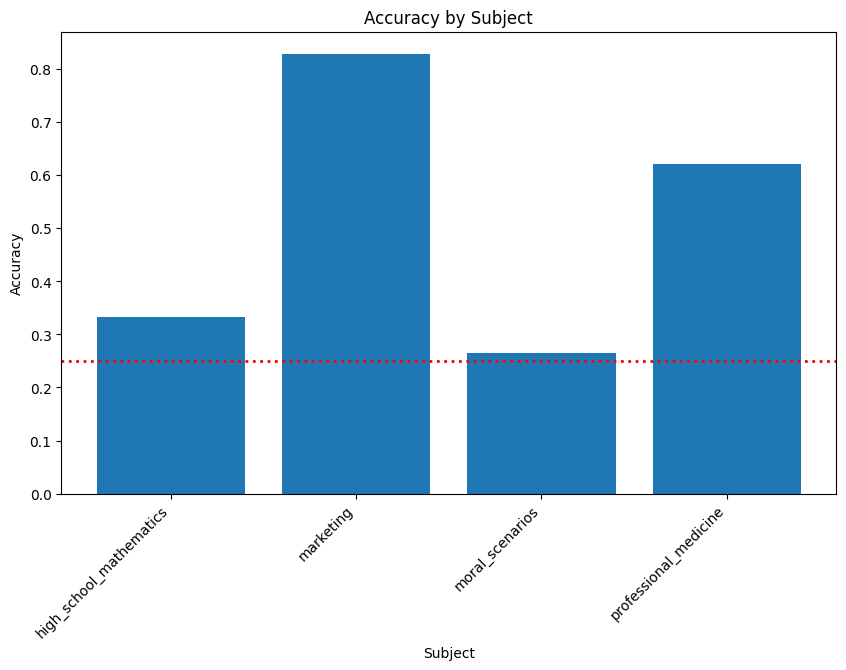

In [27]:
start_time = time.time()
subject_acc_3b_2 = []

for subject in subjects:
    ## n train is the number of training samples we show before running evaluation on a test prompt (k is 5 maximum in the MMLU dataset)
    dev_data = pd.DataFrame([ex for ex in ds["dev"] if ex["subject"] == subject])[: ntrain]
    #shuffle dev
    dev_data = dev_data.sample(frac=1).reset_index(drop=True)
    test_data = pd.DataFrame([ex for ex in ds["test"] if ex["subject"] == subject])
    #shuffle test
    test_data = test_data.sample(frac=1).reset_index(drop=True)
    ## get the correctness, probability arrays and accuracy for the subject
    cors, acc, probs = eval(subject, model, tokenizer, dev_data, test_data)
    subject_acc_3b_2.append(acc)

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# Create the bar graph
ax.bar(subjects, subject_acc_3b_2)
# rotate my x labels
ax.set_xticklabels(subjects, rotation=45, ha="right")
# Add a red dotted horizontal line at 0.25
ax.axhline(y=0.25, color='red', linestyle='dotted', linewidth=2)

# Set the title and labels
ax.set_title('Accuracy by Subject')
ax.set_xlabel('Subject')
ax.set_ylabel('Accuracy')

# Show the plot
plt.show()


## Looks like that didn't change much. Accuracy increased for some tasks and decreased for the others!



Average accuracy of model meta-llama/Llama-3.2-3B - 0.300 - high_school_mathematics
Average accuracy of model meta-llama/Llama-3.2-3B - 0.816 - marketing
Average accuracy of model meta-llama/Llama-3.2-3B - 0.247 - moral_scenarios
Average accuracy of model meta-llama/Llama-3.2-3B - 0.607 - professional_medicine
Time taken: 467.23947644233704 seconds


<ipython-input-40-b2488185fa3b>:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subjects, rotation=45, ha="right")


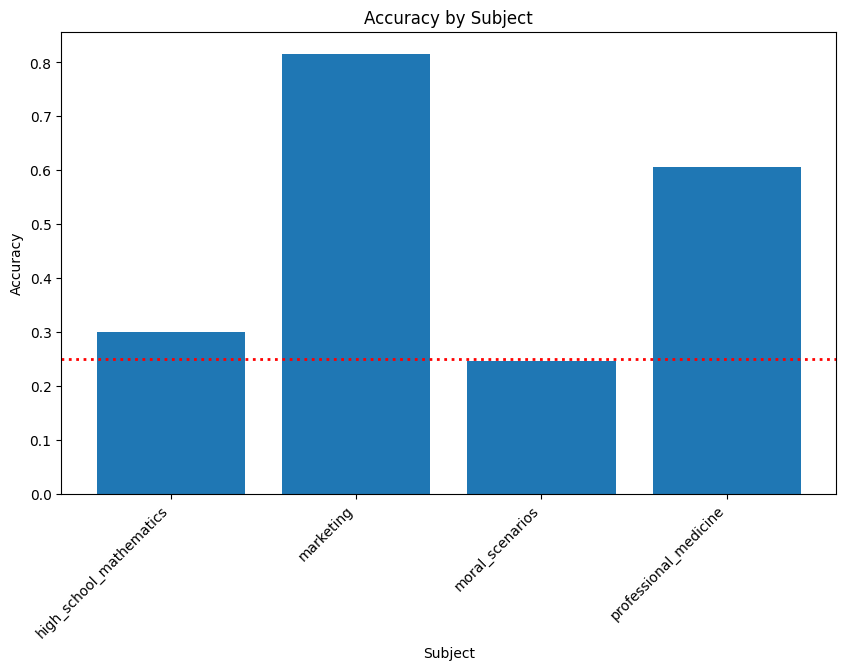

In [40]:
import random

def shuffle_choices(df):
    df = df.copy()  # Avoid modifying the original DataFrame

    for i in range(len(df)):
        choices = df.at[i, "choices"]  # Get choices list
        correct_idx = df.at[i, "answer"]  # Get correct answer index
        # Ensure choices are a list
        if not isinstance(choices, list):
            continue  # Skip if choices are not a list

        # Pair choices with their original indices
        indexed_choices = list(enumerate(choices))
        # Shuffle the choices
        random.shuffle(indexed_choices)

        # Extract new choices and create a mapping of old index -> new index
        new_choices = [choice for _, choice in indexed_choices]
        old_to_new_index = {old_idx: new_idx for new_idx, (old_idx, _) in enumerate(indexed_choices)}

        # Update correct answer index
        new_correct_idx = old_to_new_index[correct_idx]

        # Update dataframe
        df.at[i, "choices"] = new_choices
        df.at[i, "answer"] = new_correct_idx  # Update answer index

    return df


start_time = time.time()
subject_acc_3b_3 = []

for subject in subjects:
    ## n train is the number of training samples we show before running evaluation on a test prompt (k is 5 maximum in the MMLU dataset)
    dev_data = pd.DataFrame([ex for ex in ds["dev"] if ex["subject"] == subject])[: ntrain]
    #shuffle dev choices
    dev_data = shuffle_choices(dev_data)
    test_data = pd.DataFrame([ex for ex in ds["test"] if ex["subject"] == subject])
    #shuffle test choices
    test_data = shuffle_choices(test_data)
    ## get the correctness, probability arrays and accuracy for the subject
    cors, acc, probs = eval(subject, model, tokenizer, dev_data, test_data)
    subject_acc_3b_3.append(acc)

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# Create the bar graph
ax.bar(subjects, subject_acc_3b_3)
# rotate my x labels
ax.set_xticklabels(subjects, rotation=45, ha="right")
# Add a red dotted horizontal line at 0.25
ax.axhline(y=0.25, color='red', linestyle='dotted', linewidth=2)

# Set the title and labels
ax.set_title('Accuracy by Subject')
ax.set_xlabel('Subject')
ax.set_ylabel('Accuracy')

# Show the plot
plt.show()


## However, as we see above, when we shuffle the order of the choices of the questions, the accuracy goes down for all the tasks! Therefore, we show that the accuracy decreases overall when we shuffle options for each question. However, when we shuffle the order in which the questions are shown to the LLM, the change in accuracy is random.

In [26]:
from google.colab import runtime
runtime.unassign()
